# 2-1. 프로젝트: 새로운 데이터셋으로 나만의 이미지 분류기 만들어보기
* Step 1. 데이터셋 내려받기
* Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
* Step 3. 모델 설계하기
* Step 4. 모델 학습시키기
* Step 5. 모델 성능 평가하기
* Step 6. 모델 활용하기

In [12]:
import tensorflow as tf
print(tf.__version__) # 설치된 텐서플로우의 버전 확인

2.6.0


### Step 1. 데이터셋 내려받기
* 이번에는 tensorflow_datasets 에 포함된 tf_flowers 데이터를 사용해 보자. tf_flowers 데이터에 대한 정보는 다음에서 확인해볼 수 있다.
* tfds.load를 활용하여 데이터셋을 다운받는다.

https://www.tensorflow.org/datasets/catalog/tf_flowers

In [13]:
import tensorflow_datasets as tfds

tfds.__version__

'4.4.0'

In [14]:
(raw_train, raw_validation, raw_test), metadata = tfds.load( # metadata: 데이터셋의 정보를 담고 있는 메타데이터를 의미, 이 정보에는 데이터셋의 특성이나 클래스 등에 관한 정보가 포함
    name='tf_flowers', # 불러올 데이터셋
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], # 전체 'train' 데이터셋을 80%, 10%, 10%의 비율로 훈련, 검증, 테스트로 나눈다
    data_dir='~/aiffel/flowers_5/', # 저장할 디렉토리를 지정, '~/aiffel/flowers_5/' 경로에 데이터를 저장
    download=True, # 데이터를 다운로드하지 않고 로컬에서 불러오도록 설정
    with_info=True, # 데이터셋의 정보(metadata)도 함께 불러오도록 설정
    as_supervised=True, # 데이터를 (입력, 레이블) 형태로 불러온다.
)

In [15]:
# 데이터셋 확인하기
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


### 데이터 시각화를 통해 확인하고, 모델에 입력할 수 있는 형태로 전처리하기

In [16]:
# 데이터 확인을 위해 matplotlib 라이브러리 가져오기
import matplotlib.pyplot as plt
%matplotlib inline # Jupyter Notebook이나 Jupyter Lab 등에서 Matplotlib으로 생성된 그림을 노트북 내에서 바로 볼 수 있도록 하는 명령어
%config InlineBackend.figure_format = 'retina' # 레티나 디스플레이를 지원하는 환경에서는 고해상도 그림을 출력하기 위한 설정

print("슝~")

UsageError: unrecognized arguments: # Jupyter Notebook이나 Jupyter Lab 등에서 Matplotlib으로 생성된 그림을 노트북 내에서 바로 볼 수 있도록 하는 명령어


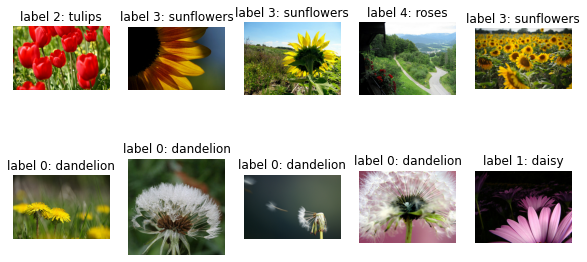

In [17]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str # 데이터셋의 메타데이터에서 레이블 정보를 활용하여 숫자 형태의 레이블을 해당하는 이름으로 변환하는 함수

for idx, (image, label) in enumerate(raw_train.take(10)): # 10개의 데이터를 가져온다
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [18]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32) # image=float(image)같은 타입캐스팅의 텐서플로우 버전
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

print("슝~")

슝~


In [19]:
train = raw_train.map(format_example) # format_example은 이미지 resize 함수
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


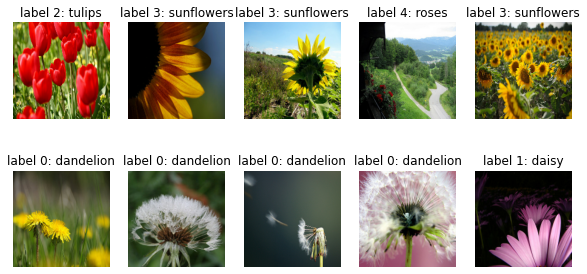

In [20]:
# 다시 이미지를 시각적으로 확인해 보자
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx +1)
    image = (image + 1) / 2 # matplotlib으로 이미지를 시각화 할 경우에는 모든 픽셀값이 양수여야 하므로, 
                            # -1~1 사이의 픽셀값을 1을 더한 후 2로 나눠서 0~1 사이의 값으로 변환
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

In [24]:
# 한 스텝에 학습시킬 데이터의 개수: BATCH_SIZE, 학습 데이터를 적절히 섞어줄 SHUFFLE_BUFFER_SIZE를 설정
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
print("슝~")

슝~


BATCH_SIZE에 따라 32개의 데이터를 랜덤으로 뿌려줄 train_batches, validation_batches, test_batches를 만들어 준다. train_batches는 모델이 끊임없이 학습될 수 있도록 전체 데이터에서 32개를 랜덤으로 뽑아 계속 제공해 줄 것이다.

In [25]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)
print("슝~")

슝~


In [26]:
# train_batches에서 하나의 batch만 꺼내 데이터를 확인
for image_batch, label_batch in train_batches.take(1):
    break
    
image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

### Step 3. 모델 설계하기

* **사전 학습 모델인 VGG16을 가져오고, 모델의 구조 확인하기**

2014년의 ILSVRC 물체 위치 찾기(localization) 태스크에서 우승한 VGG 모델을 사용해 보자.
2014년 이후 뛰어난 성능을 보이는 다양한 새로운 모델이 개발되었지만, VGG는 단순한 구조임에도 꽤나 괜찮은 성능을 보여서 아직까지 많은 이미지 처리 분야에서 사랑받는 모델 중 하나이다.

다음의 간단한 코드로 VGG 모델을 base_model의 변수로 불러오겠다. **이전 스텝에 언급한 대로, VGG 모델을 가져올 때, output에 가까운 높은 레벨에 있는 3개의 FC 레이어는 제외하고 불러와야 하므로 include_top=False 옵션을 주었다는 것을 눈여겨 보자.**

텐서플로우 케라스에서 제공하는 VGG16 모델에 대한 상세한 내용은 아래 링크를 참고
: https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16

In [27]:
# 모델 생성에 필요한 함수들을 불러오기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

print("슝~")

슝~


In [28]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, 
                                         include_top=False, 
                                         weights='imagenet') # tf.keras.applications.VGG16에서 weights='imagenet'를 설정하면 사전에 ImageNet 데이터셋으로 훈련된 가중치를 사용하여 VGG16 모델을 로드할 수 있다. 
                                                            # 이를 통해 일반적인 이미지 분류 작업에 더 좋은 성능을 기대할 수 있다. 
                                                            # 이미지넷 데이터셋으로 미리 학습된 가중치들은 다양한 특징을 감지하도록 조정되어 있어 다양한 이미지 분류 과제에서 유용하게 사용

58900480/58889256 [==============================] - 1s 0us/step


In [29]:
# image_batch의 원래 사이즈를 다시 확인
image_batch.shape

TensorShape([32, 160, 160, 3])

모델에 이 배치를 넣으면 shape가 어떻게 바뀔까?

In [30]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

이미지의 개수는 32장으로 여전히 같은데, 이미지의 사이즈가 많이 달라졌다.

height와 width는 각각 5로 매우 작아졌고, 512로 channel이 늘어났다.

이 벡터는 이미지에서 특징을 추출해 낸 "특징 벡터"라고 부르기도 한다.

그렇다면 모델 구조는 어떤지 살펴보자.

In [31]:
# 모델 구조 확인
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

우리는 이 모델을 그대로 쓰지 않고 Transfer Learning 시킬 것이기 때문에 Dense Layer는 쓰지 않는다. 이 부분은 우리가 새로 만들어주어야 한다.

### VGG16 끝단에 classifier 레이어를 붙여서 원하는 구조의 분류 모델 만들기

In [32]:
import numpy as np

image = np.array([[1, 2],
                  [3, 4]])
                  
flattened_image = image.flatten()

print("Original image:\n", image)
print("Original image shape:", image.shape)
print()
print("Flattened image:\n", flattened_image)
print("Flattened image shape:", flattened_image.shape)

Original image:
 [[1 2]
 [3 4]]
Original image shape: (2, 2)

Flattened image:
 [1 2 3 4]
Flattened image shape: (4,)


2차원 또는 3차원 벡터를 1차원으로 축소하는 방법에는 Flattening 하는 것보다 조금 더 좋은 방법이 있다.

그 방법은 바로 Global Average Pooling이다.

**GAP의 목적은 feature를 1차원 벡터로 만들기 위함이다.**


Global Average Pooling은 위와 같이 3차원의 벡터가 있을 때, 겹겹이 쌓여있는 2차원 배열의 평균을 구한 후 하나의 값으로 축소하는 기법이다.

위 그림에서는 왼쪽의 3차원 배열에서 맨 앞 장인 [[1, 5, 4, 5], ..., [8, 6, 8, 7]] 에 있는 16개 숫자의 평균을 구하면 '5'라는 숫자가 된다.

이와 같이 평균값을 활용해 벡터의 차원을 줄이는 방법 을 Global Average Pooling이라고 한다.

In [34]:
# Global Average Pooling 계층을 만드는 코드를 확인
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
print("슝~")

슝~


global_average_layer에 위에서 VGG16이 출력했던 feature_batch를 입력하면 어떻게 될까?

In [35]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [64]:
# dense layer에는 unit과 activation 2개의 매개변수만 사용해주세요.
# unit의 값은 위에서 global_average_layer를 통과했을 때의 값을 생각해보세요.
# 활성화 함수는 ReLU를 사용합니다.
dense_layer1 = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal') # he 초기값 설정
dropout_layer2 = tf.keras.layers.Dropout(0.5) # 드롭아웃 추가
dense_layer3 = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal') # he 초기값 설정 및 dense 레이어 추가
# unit은 우리가 분류하고 싶은 class를 생각해보세요.
# 활성화 함수는 Softmax를 사용합니다.
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)
# dense_layer = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')
# dropout_layer = tf.keras.layers.Dropout(0.5)
# dense_layer2 = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')

# prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# output_from_dense = dense_layer(feature_batch_average)
# output_after_dropout = dropout_layer(output_from_dense)
# prediction_batch = prediction_layer(output_after_dropout)
# print(prediction_batch.shape)

(32, 5)


우리의 데이터들은 처음에 이미지에서 특징을 추출해 줄 VGG16, base_model에 입력되어 특징이 추출된 다음, 그 특징 벡터는 global_average_layer를 거쳐 마지막에 prediction_layer까지 통과하며 꽃은 분류할 것이다.

여기에서, VGG16에 해당하는 base_model은 학습을 시키지 않을 예정이니 학습 여부를 결정하는 trainable 변수를 False로 지정해 "꺼주겠"다.

In [65]:
base_model.trainable = False
print("슝~")

슝~


In [66]:
# 최종 모델 만들기
model = tf.keras.Sequential([
    base_model, 
    global_average_layer, 
    dense_layer1,
    dropout_layer2,
    dense_layer3, 
    prediction_layer
])
print("슝~")

슝~


In [67]:
# 모델 구조 확인
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 2565      
Total params: 15,242,565
Trainable params: 527,877
Non-trainable params: 14,714,688
____________________________________

In [68]:
# compile 코드 작성
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])

print("슝~")

슝~


In [69]:
# 초기 손실과 정확도 값을 확인
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/20 [===============>..............] - ETA: 0s - loss: 1.6837 - accuracy: 0.2727WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 1s 38ms/step - loss: 1.6865 - accuracy: 0.2698
initial loss: 1.69
initial accuracy: 0.27


### Step 5. 모델 성능 평가하기

In [73]:
# 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

EPOCHS = 50  
history = model.fit(train_batches, 
                    epochs=EPOCHS,
                    validation_data=validation_batches, callbacks=early_stopping)

Epoch 1/50
92/92 [==============================] - 8s 81ms/step - loss: 0.7339 - accuracy: 0.7306 - val_loss: 0.6297 - val_accuracy: 0.7575
Epoch 2/50
92/92 [==============================] - 8s 81ms/step - loss: 0.6949 - accuracy: 0.7480 - val_loss: 0.6010 - val_accuracy: 0.7575
Epoch 3/50
92/92 [==============================] - 8s 81ms/step - loss: 0.6607 - accuracy: 0.7643 - val_loss: 0.5615 - val_accuracy: 0.7847
Epoch 4/50
92/92 [==============================] - 8s 82ms/step - loss: 0.6353 - accuracy: 0.7725 - val_loss: 0.5614 - val_accuracy: 0.7793
Epoch 5/50
92/92 [==============================] - 8s 83ms/step - loss: 0.6060 - accuracy: 0.7820 - val_loss: 0.5379 - val_accuracy: 0.7902
Epoch 6/50
92/92 [==============================] - 8s 82ms/step - loss: 0.5855 - accuracy: 0.7868 - val_loss: 0.5514 - val_accuracy: 0.7929
Epoch 7/50
92/92 [==============================] - 8s 82ms/step - loss: 0.5689 - accuracy: 0.8021 - val_loss: 0.5104 - val_accuracy: 0.8011
Epoch 8/50
92

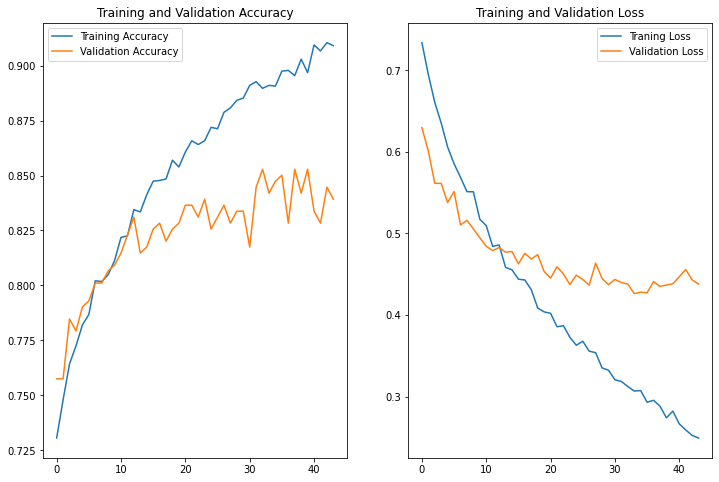

In [77]:
# 학습 단계에 따른 정확도 변화를 그래프로 확인해 보자.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Traning Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [78]:
# 32개의 test sample에 대한 예측 결과
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[7.75016786e-04, 2.49477173e-03, 9.48725462e-01, 1.39974186e-03,
        4.66051139e-02],
       [9.99999404e-01, 6.13504255e-07, 3.16391940e-10, 1.46135362e-08,
        2.26856223e-08],
       [7.45645344e-01, 1.47723198e-01, 9.87185724e-03, 8.58915746e-02,
        1.08680828e-02],
       [2.78583448e-05, 9.25701679e-05, 6.51547372e-01, 5.20865615e-05,
        3.48280042e-01],
       [8.11990976e-01, 1.82861313e-01, 1.50634279e-03, 1.65264821e-03,
        1.98876509e-03],
       [9.91787016e-01, 6.78789616e-03, 6.19023558e-05, 1.33819692e-03,
        2.49385957e-05],
       [2.50760088e-04, 1.23637030e-04, 9.93409812e-01, 1.64088490e-03,
        4.57483856e-03],
       [2.14270666e-01, 7.78285086e-01, 3.84498635e-05, 7.22576678e-03,
        1.80110466e-04],
       [1.07948959e-03, 4.77426620e-05, 1.50560774e-02, 9.63956654e-01,
        1.98601261e-02],
       [9.99998450e-01, 1.39248004e-06, 7.21839144e-10, 1.10740665e-07,
        6.67354394e-09],
       [9.94628012e-01, 4.8737

In [79]:
# prediction 값들을 실제 추론한 라벨(고양이:0, 강아지:1)로 변환
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 2, 4, 4, 3, 0, 4])

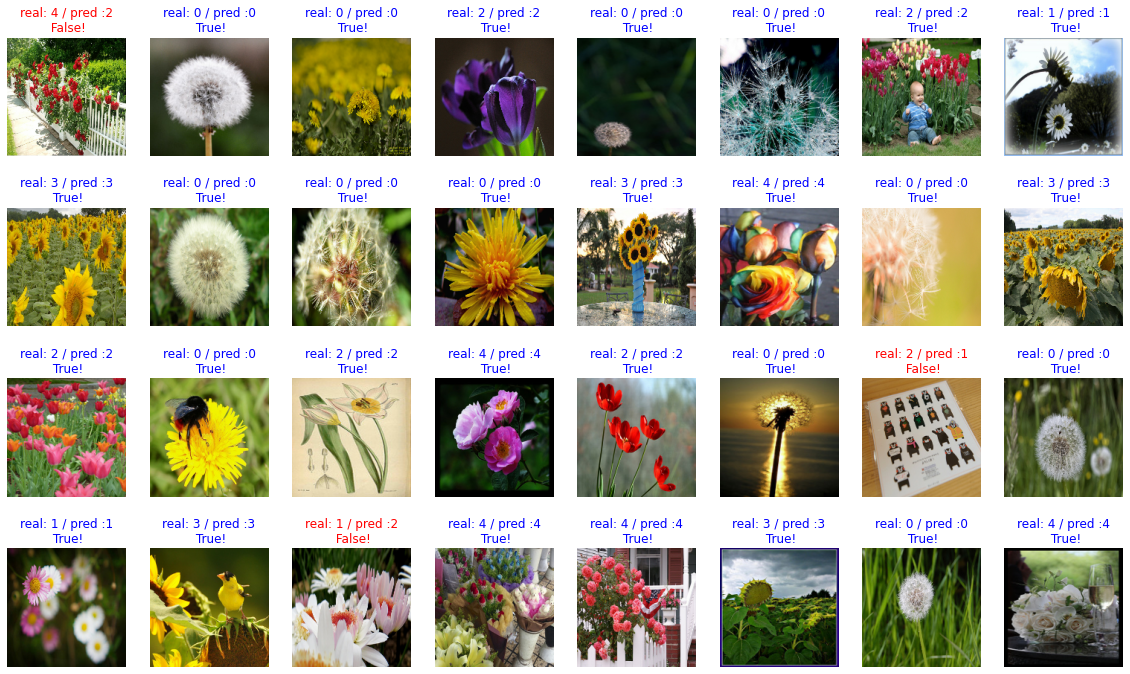

In [80]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [81]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)

90.625


In [89]:
# test_accuracy 측정
test_loss, test_accuracy = model.evaluate(test_batches, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

12/12 - 1s - loss: 0.3876 - accuracy: 0.8665
test_loss: 0.3875771164894104
test_accuracy: 0.8664849996566772
